In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# download movie data and make directory for the model

#! wget -q http://files.grouplens.org/datasets/movielens/ml-1m.zip
#! unzip ml-1m.zip
! mkdir mf_model
!mkdir cache

mkdir: cannot create directory ‘mf_model’: File exists
mkdir: cannot create directory ‘cache’: File exists


In [4]:
age_desc = {
    1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"
}
occupation_desc = { 
    0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
    4: "college/grad student", 5: "customer service", 6: "doctor/health care",
    7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
    12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
    17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
}
rating_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=['userid', 'movieid', 'rating', 'timestamp'])

user_data = pd.read_csv(
    "ml-1m/users.dat", 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['userid', 'gender', 'age', 'occupation', 'zipcode']
)
user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])

movie_data = pd.read_csv(
    "ml-1m/movies.dat",
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['movieid', 'title', 'genre']
)

dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")

In [5]:
def check_cols(df, cols):
    """
    check if there are gaps of index, and if the index starts from 0
    
    Arguments:
    df -- dataframe of the dataset
    cols -- dataframe columns that needs to be checked, in our case user id and movie id
    
    Returns:
    a list of tuple [('COLUMN_NAME', boolean)], if True, the column needs to be fixed, if False, the column is ok.
    """
    return [(col, False) if len(dataset[col].unique())-1 == dataset[col].max() else (col, True) for col in cols]

def remove_gaps(df, col):
    """
    preprocess the index of user id and movie id to start from 0 and reduce the gap of index
    
    Arguments:
    df -- dataframe of the dataset
    col -- dataframe columns that needs to be adjusted, in our case both user id and movie id
    
    Returns:
    a dataframe with adjusted columns.
    """
    adj_col_uni = df[col].sort_values().unique()
    adj_df = pd.DataFrame(adj_col_uni).reset_index().rename(columns = {0: col, 'index': "adj_%s"%(col,)})
    return pd.merge(adj_df, df, how="right", on=col)

In [6]:
index_cols = ["userid", "movieid"]
cols_check = check_cols(dataset, index_cols)
print_check = lambda check: print(*["%s needs fix!"%(c,) if f else "%s ok."%(c,) for c, f in check], sep="\n")
print("before fix:")
print_check(cols_check)
for col, needs_fix in cols_check:
    if needs_fix:
        dataset = remove_gaps(dataset, col)

print("\nafter fix")
print_check(check_cols(dataset, ["adj_userid", "adj_movieid"]))

before fix:
userid needs fix!
movieid needs fix!

after fix
adj_userid ok.
adj_movieid ok.


In [7]:
dataset = dataset.sample(frac=1, replace=False)
n_split = int(len(dataset)*.7)
trainset = dataset[:n_split]
validset = dataset[n_split:]

In [8]:
emb_dim = 8

In [9]:
def initialize_embeddings(num_users, num_movies, dim):
    """
    initialize embeddings, user_embedding and movie_embedding are the user features and movie features 
    that needs to be learned by the matrix factorization model.
    
    Arguments:
    num_users -- user index
    num_movies -- movies index
    dim -- dimension of learned user and movie features, it's a hyper-parameter
    
    Returns:
    user_embeddings -- a matrix of shape [number of training examples, dim]
    movie_embeddings -- a matrix of shape [number of training examples, dim]
    """    
    user_embeddings = tf.get_variable(
        "theta",
        initializer=tf.truncated_normal_initializer(mean=0, stddev=.05),
        shape=[num_users, dim],
        dtype=tf.float32
    )
    movie_embeddings = tf.get_variable(
        "phi",
        initializer=tf.truncated_normal_initializer(mean=0, stddev=.05),
        shape=[num_movies, dim],
        dtype=tf.float32
    )
    return (user_embeddings, movie_embeddings)

def create_dataset(user_ids, movie_ids, ratings):
    """
    initialize ids, user id and movie id  
    that needs to be learned by the matrix factorization model.
    
    Arguments:
    num_users -- number of users
    num_movies -- number of movies
    dim -- dimension of learned user and movie features, it's a hyper-parameter
    
    Returns:
    user_embeddings -- a matrix of shape [number of training examples, dim]
    movie_embeddings -- a matrix of shape [number of training examples, dim]
    """     
    user_id_var = tf.get_variable("userid", initializer=user_ids, trainable=False)
    movie_id_var = tf.get_variable("movieid", initializer=movie_ids, trainable=False)
    ratings_var = tf.get_variable("ratings", initializer=np.asarray(ratings, dtype=np.int32), trainable=False)
    return (user_id_var, movie_id_var, ratings_var)

def lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids):
    """
    lookup the embeddings based on ids
    
    Arguments:
    num_users -- number of users
    num_movies -- number of movies
    dim -- dimension of learned user and movie features, it's a hyper-parameter
    
    Returns:
    user_embeddings -- a matrix of shape [number of training examples, dim]
    movie_embeddings -- a matrix of shape [number of training examples, dim]
    """ 
    selected_user_embeddings = tf.gather(user_embeddings, user_ids)
    selected_movie_embeddings = tf.gather(movie_embeddings, movie_ids)
    return (selected_user_embeddings, selected_movie_embeddings)

def predict(selected_user_embeddings, selected_movie_embeddings):
    selected_predictions = tf.reduce_sum(
        selected_user_embeddings * selected_movie_embeddings,
        axis = 1
    )
    return selected_predictions

def matrix_factorization(user_embeddings, movie_embeddings, user_ids, movie_ids):
    sel_usr_embs, sel_mov_embs = lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids)
    predictions = predict(sel_usr_embs, sel_mov_embs)
    return predictions

def mean_squared_difference(predictions, ratings):
    difference = tf.reduce_mean(tf.squared_difference(predictions, tf.cast(ratings, tf.float32)))
    return difference

In [10]:
mf_learning_rate = 50
mf_epochs = 1400

n_users = dataset.adj_userid.max()+1
n_movies = dataset.adj_movieid.max()+1

def mf_train(emb_dim, n_users, n_movies, trainset, validset, learning_rate, epochs):
    with tf.Graph().as_default():
        with tf.variable_scope("embeddings"):
            usr_embs, mov_embs = initialize_embeddings(n_users, n_movies, emb_dim)
        with tf.variable_scope("train_set"):
            train_data = trainset[["adj_userid", "adj_movieid", "rating"]].values.T
            train_usr_ids, train_mov_ids, train_ratings = create_dataset(*train_data)
        with tf.variable_scope("valid_set"):
            valid_data = validset[["adj_userid", "adj_movieid", "rating"]].values.T
            valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
        with tf.variable_scope("training"):
            train_preds = matrix_factorization(usr_embs, mov_embs, train_usr_ids, train_mov_ids)
            train_loss = mean_squared_difference(train_preds, train_ratings)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
            train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs])
        with tf.variable_scope("validation"):
            valid_preds = matrix_factorization(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
            valid_loss = mean_squared_difference(valid_preds, valid_ratings)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            train_loss_history = []
            valid_loss_history = []
            for i in range(epochs):
                current_train_loss, _ = sess.run([train_loss, train_usr_embs])
                current_train_loss, _ = sess.run([train_loss, train_mov_embs])
                current_valid_loss = sess.run(valid_loss)
                if i%50 == 0:
                    print("valid loss at step %i: %f"%(i+1, current_valid_loss))
                train_loss_history.append(current_train_loss)
                valid_loss_history.append(current_valid_loss)
            final_user_embeddings, final_movie_embeddings = sess.run([usr_embs, mov_embs])
            final_valid_predictions = sess.run(valid_preds)
    return (final_user_embeddings, final_movie_embeddings, train_loss_history, valid_loss_history, final_valid_predictions)

mf_result = mf_train(emb_dim, n_users, n_movies, trainset, validset, mf_learning_rate, mf_epochs)
mf_user_embs, mf_movie_embs, mf_tlh, mf_vlh, mf_fvp = mf_result

np.save("mf_model/user_embeddings", mf_user_embs)
np.save("mf_model/movie_embeddings", mf_movie_embs)

print("embeddings saved")

valid loss at step 1: 14.084263
valid loss at step 51: 3.059916
valid loss at step 101: 1.085831
valid loss at step 151: 0.921573
valid loss at step 201: 0.872598
valid loss at step 251: 0.845102
valid loss at step 301: 0.823998
valid loss at step 351: 0.807723
valid loss at step 401: 0.795379
valid loss at step 451: 0.785952
valid loss at step 501: 0.778722
valid loss at step 551: 0.773286
valid loss at step 601: 0.769354
valid loss at step 651: 0.766600
valid loss at step 701: 0.764695
valid loss at step 751: 0.763373
valid loss at step 801: 0.762450
valid loss at step 851: 0.761804
valid loss at step 901: 0.761361
valid loss at step 951: 0.761070
valid loss at step 1001: 0.760897
valid loss at step 1051: 0.760820
valid loss at step 1101: 0.760819
valid loss at step 1151: 0.760880
valid loss at step 1201: 0.760992
valid loss at step 1251: 0.761146
valid loss at step 1301: 0.761333
valid loss at step 1351: 0.761549
embeddings saved


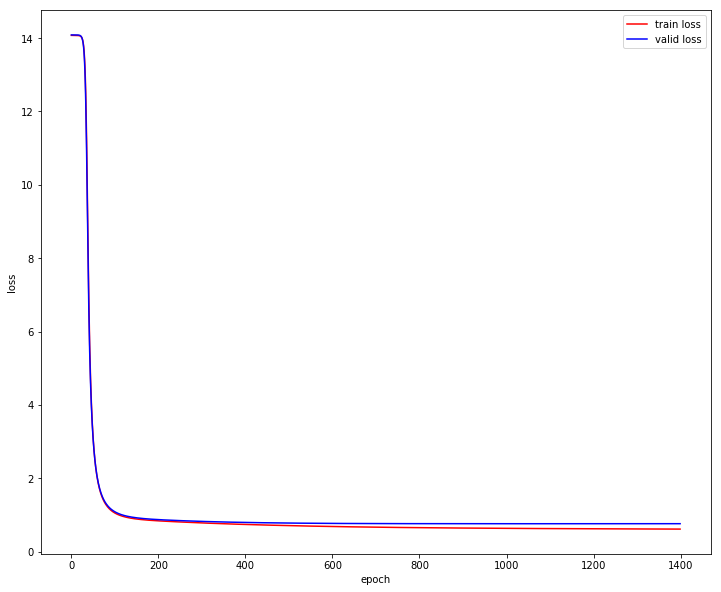

In [11]:
plt.figure(figsize=(12,10))
plt.plot(np.array(mf_tlh), color="red", label="train loss")
plt.plot(np.array(mf_vlh), color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [12]:
def load_embeddings(user_embs_file, movie_embs_file):
    """
    In the deep model we initialize the user embedding and movie embedding with value that learned from matrix factorization.
    So here load already saved values in. 
    
    Arguments:
    user_embs_file -- saved user embedding array
    movie_embs_file -- saved movie embedding array
    
    Returns:
    usr_embs -- initialized user embeddings
    mov_embs -- initialized user embeddings
    """       

    usr_embs_array = np.load(user_embs_file)
    mov_embs_array = np.load(movie_embs_file)
    usr_embs = tf.get_variable(
        "usr_embs",
        initializer = tf.constant_initializer(usr_embs_array),
        shape = usr_embs_array.shape
    )
    mov_embs = tf.get_variable(
        "mov_embs",
        initializer = tf.constant_initializer(mov_embs_array),
        shape = mov_embs_array.shape
    )
    return (usr_embs, mov_embs)


def initialize_nn_params(net_dims):
    """
    Initializes parameters for the whole nn. 
    net_dims -- dim_in, d_1, ..., d_n
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1,...Wn, bn
    """
    layer_dims = list(zip(net_dims[:-1], net_dims[1:]))
    #params = {"n_layers": len(layer_dims)}
    params = {}
    for i, (n_in, n_out) in enumerate(layer_dims):
        params["W"+str(i+1)] = tf.get_variable(
            "W"+str(i+1), 
            [n_in, n_out], 
            initializer = tf.contrib.layers.xavier_initializer(seed =1)
        )
        params["b"+str(i+1)] = tf.get_variable(
            "b"+str(i+1), 
            [1,n_out], 
            initializer = tf.zeros_initializer()
        )
    return params

In [13]:
def forward_propagate(inputs, params, acts, net_dims):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    inputs -- input comes from user and movie embedding
    params -- python dictionary containing parameters "W1", "b1", "W2", "b2", "W3", "b3"
    acts -- activation function, this is a list ['tf.nn.relu', 'tf.nn.relu', 'None']

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    a = inputs
    n_layers = len(net_dims)-1
    for i in range(n_layers):
        W = params['W'+str(i+1)]
        b = params['b'+str(i+1)]
        z = tf.matmul(a, W) + b
        a = acts[i](z) if acts[i] is not None else z
    return a

In [14]:
def calc_predict(logits):
    """
    Calculate predictions
    
    Arguments:
    logits -- a

    Returns:
    prediction -- softmax of a
    """
    return tf.nn.softmax(logits)

In [15]:
def cross_entropy(a, ratings):
    """
    Computes the cross entropy
    
    Arguments:
    a -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 5)
    y -- "true" labels vector placeholder, same shape as a
    
    Returns:
    cross_entropy - Tensor of the cross_entropy function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = a
    labels = ratings-1
    
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cross_entropy

In [16]:
def mean_squared_error2(predictions, ratings):
    """
    Computes the cost
    
    Arguments:
    a -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 5)
    y -- "true" labels vector placeholder, same shape as a
    
    Returns:
    cost - Tensor of the cost function
    """
    mean_squared_error=tf.reduce_mean(tf.squared_difference(tf.cast(tf.argmax(predictions, axis = 1),tf.float32), tf.cast(ratings-1, tf.float32)))
    return mean_squared_error

In [17]:
def mean_squared_error(predictions, ratings):
    stars = tf.range(1,6)
    distances = (stars - tf.tile(tf.expand_dims(ratings, -1), [1, 5]))**2
    mean_distance = tf.reduce_mean(tf.reduce_sum(predictions * tf.cast(distances, tf.float32), axis=-1))
    return mean_distance

In [18]:
def dfm_loss(logits, ratings, params, alpha, beta):
    predictions = calc_predict(logits)
    loss = alpha * mean_squared_error(predictions, ratings) + (1-alpha) * cross_entropy(logits, ratings)
    
    reg = 0
    for n, p in params.items():
        reg = reg + tf.reduce_mean(p**2)
    return loss + beta*reg

In [19]:
def dmf_logits(user_ids, movie_ids, user_embeddings, movie_embeddings, params, acts, net_dims):
    sel_usr_embs, sel_mov_embs = lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids)
    inputs = sel_usr_embs * sel_mov_embs
    predicted_rating_logits = forward_propagate(inputs, params, acts, net_dims)
    return predicted_rating_logits

In [20]:
user_embs_file = "mf_model/user_embeddings.npy"
movie_embs_file = "mf_model/movie_embeddings.npy"

bs = 4096
epochs = 1000
end_to_end_start = 50
nn_lr = 0.001
eb_lr = 0.0001
alpha = 0.5
beta = 1.75
net_dims = [8, 64, 32, 16, 5]
acts = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None]

with tf.Graph().as_default():
    tf.set_random_seed(seed=123)
    with tf.variable_scope("embeddings"):
        usr_embs, mov_embs = load_embeddings(user_embs_file, movie_embs_file)
    with tf.variable_scope("neural_network"):
        params = initialize_nn_params(net_dims)
    with tf.variable_scope("train_set"):
        train_data = trainset[["adj_userid", "adj_movieid", "rating"]].values.T
        train_examples = create_dataset(*train_data)
        train_batches = tf.contrib.data.Dataset.from_tensor_slices(train_examples).batch(bs).cache("ds_cache")
        train_iterator = train_batches.make_initializable_iterator()
        train_usr_id_bs, train_mov_id_bs, train_rating_bs = train_iterator.get_next()
    with tf.variable_scope("valid_set"):
        valid_data = validset[["adj_userid", "adj_movieid", "rating"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_logits_bs = dmf_logits(train_usr_id_bs, train_mov_id_bs, usr_embs, mov_embs, params, acts, net_dims)
        train_loss = dfm_loss(train_logits_bs, train_rating_bs, params, alpha, beta)
        train_step_nn = tf.train.AdamOptimizer(learning_rate=nn_lr).minimize(train_loss, var_list=list(params.values()))
        train_step_eb = tf.train.AdamOptimizer(learning_rate=eb_lr).minimize(train_loss, var_list=[list(params.values())+[usr_embs, mov_embs]])
    with tf.variable_scope("validation"):
        valid_logits = dmf_logits(valid_usr_ids, valid_mov_ids, usr_embs, mov_embs, params, acts, net_dims)
        valid_preds = calc_predict(valid_logits)
        #cost = cross_entropy(valid_logits, valid_ratings)
        valid_loss = dfm_loss(valid_logits, valid_ratings, params, alpha, beta)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(train_iterator.initializer)
        train_loss_history = []
        valid_loss_history = []
        for epoch in range(epochs):
            try:
                train_epoch_loss_history = []
                while True:
                    if epoch < end_to_end_start:
                        current_train_loss = sess.run([train_loss, train_step_nn])[0]
                    else:
                        current_train_loss = sess.run([train_loss, train_step_eb])[0]
                    train_epoch_loss_history.append(current_train_loss)
            except tf.errors.OutOfRangeError:
                train_epoch_loss = np.mean(train_epoch_loss_history)
                train_loss_history.append(train_epoch_loss)
                valid_epoch_loss = sess.run(valid_loss)
                valid_loss_history.append(valid_epoch_loss)
                print("%i: %f/%f"%(epoch+1, train_epoch_loss, valid_epoch_loss), end="; ")
                sess.run(train_iterator.initializer)
        print("done!")
        final_valid_predictions = sess.run(valid_preds)

1: 1.901972/1.652957; 2: 1.443711/1.469562; 3: 1.354886/1.434016; 4: 1.327870/1.417167; 5: 1.314596/1.407984; 6: 1.307006/1.402406; 7: 1.302190/1.398685; 8: 1.298887/1.396044; 9: 1.296514/1.394101; 10: 1.294780/1.392669; 11: 1.293510/1.391616; 12: 1.292553/1.390808; 13: 1.291816/1.390179; 14: 1.291240/1.389685; 15: 1.290786/1.389292; 16: 1.290417/1.388974; 17: 1.290112/1.388717; 18: 1.289852/1.388490; 19: 1.289631/1.388298; 20: 1.289438/1.388129; 21: 1.289274/1.387981; 22: 1.289131/1.387849; 23: 1.289012/1.387741; 24: 1.288908/1.387647; 25: 1.288820/1.387566; 26: 1.288743/1.387494; 27: 1.288678/1.387434; 28: 1.288621/1.387373; 29: 1.288571/1.387328; 30: 1.288528/1.387287; 31: 1.288490/1.387252; 32: 1.288457/1.387221; 33: 1.288428/1.387191; 34: 1.288403/1.387165; 35: 1.288381/1.387139; 36: 1.288361/1.387124; 37: 1.288343/1.387103; 38: 1.288328/1.387086; 39: 1.288314/1.387072; 40: 1.288301/1.387061; 41: 1.288290/1.387053; 42: 1.288280/1.387045; 43: 1.288271/1.387039; 44: 1.288263/1.38703

347: 1.209369/1.276359; 348: 1.209258/1.276233; 349: 1.209148/1.276108; 350: 1.209038/1.275981; 351: 1.208928/1.275856; 352: 1.208819/1.275731; 353: 1.208710/1.275607; 354: 1.208601/1.275483; 355: 1.208493/1.275359; 356: 1.208385/1.275236; 357: 1.208277/1.275114; 358: 1.208169/1.274992; 359: 1.208062/1.274872; 360: 1.207956/1.274750; 361: 1.207849/1.274630; 362: 1.207743/1.274509; 363: 1.207637/1.274391; 364: 1.207532/1.274270; 365: 1.207427/1.274151; 366: 1.207322/1.274034; 367: 1.207217/1.273917; 368: 1.207112/1.273800; 369: 1.207008/1.273683; 370: 1.206904/1.273566; 371: 1.206801/1.273449; 372: 1.206698/1.273333; 373: 1.206595/1.273215; 374: 1.206492/1.273100; 375: 1.206390/1.272985; 376: 1.206288/1.272871; 377: 1.206186/1.272757; 378: 1.206084/1.272644; 379: 1.205983/1.272532; 380: 1.205882/1.272421; 381: 1.205781/1.272308; 382: 1.205681/1.272196; 383: 1.205580/1.272085; 384: 1.205480/1.271974; 385: 1.205381/1.271863; 386: 1.205281/1.271753; 387: 1.205182/1.271643; 388: 1.205083/1.

689: 1.184140/1.250341; 690: 1.184091/1.250297; 691: 1.184042/1.250253; 692: 1.183993/1.250210; 693: 1.183945/1.250166; 694: 1.183896/1.250122; 695: 1.183847/1.250079; 696: 1.183799/1.250036; 697: 1.183751/1.249992; 698: 1.183703/1.249949; 699: 1.183655/1.249906; 700: 1.183607/1.249862; 701: 1.183559/1.249820; 702: 1.183511/1.249777; 703: 1.183464/1.249734; 704: 1.183416/1.249693; 705: 1.183368/1.249650; 706: 1.183321/1.249607; 707: 1.183273/1.249565; 708: 1.183227/1.249522; 709: 1.183179/1.249480; 710: 1.183132/1.249438; 711: 1.183085/1.249396; 712: 1.183038/1.249355; 713: 1.182991/1.249314; 714: 1.182944/1.249273; 715: 1.182897/1.249230; 716: 1.182851/1.249189; 717: 1.182805/1.249148; 718: 1.182758/1.249107; 719: 1.182712/1.249065; 720: 1.182665/1.249025; 721: 1.182619/1.248984; 722: 1.182573/1.248943; 723: 1.182528/1.248904; 724: 1.182481/1.248863; 725: 1.182435/1.248823; 726: 1.182389/1.248783; 727: 1.182344/1.248742; 728: 1.182298/1.248702; 729: 1.182252/1.248662; 730: 1.182206/1.

In [21]:
dnn_accuracy = np.sum(np.argmax(final_valid_predictions, axis=-1)+1 == validset.rating.values) / len(final_valid_predictions)
print("DNN Accuracy: %f%%"%(dnn_accuracy*100,))

DNN Accuracy: 50.409081%


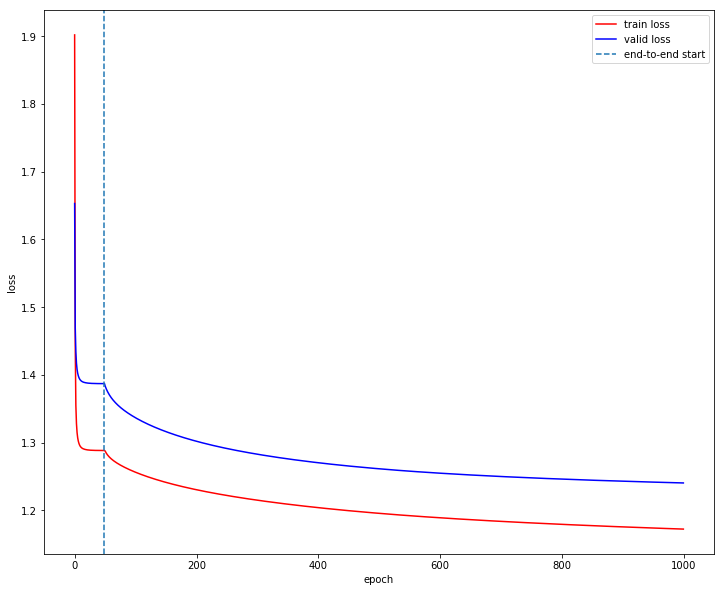

In [22]:
plt.figure(figsize=(12,10))
plt.plot(train_loss_history, color="red", label="train loss")
plt.plot(valid_loss_history, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.axvline(end_to_end_start-1, ls = "--", label="end-to-end start")
plt.legend()
plt.show()

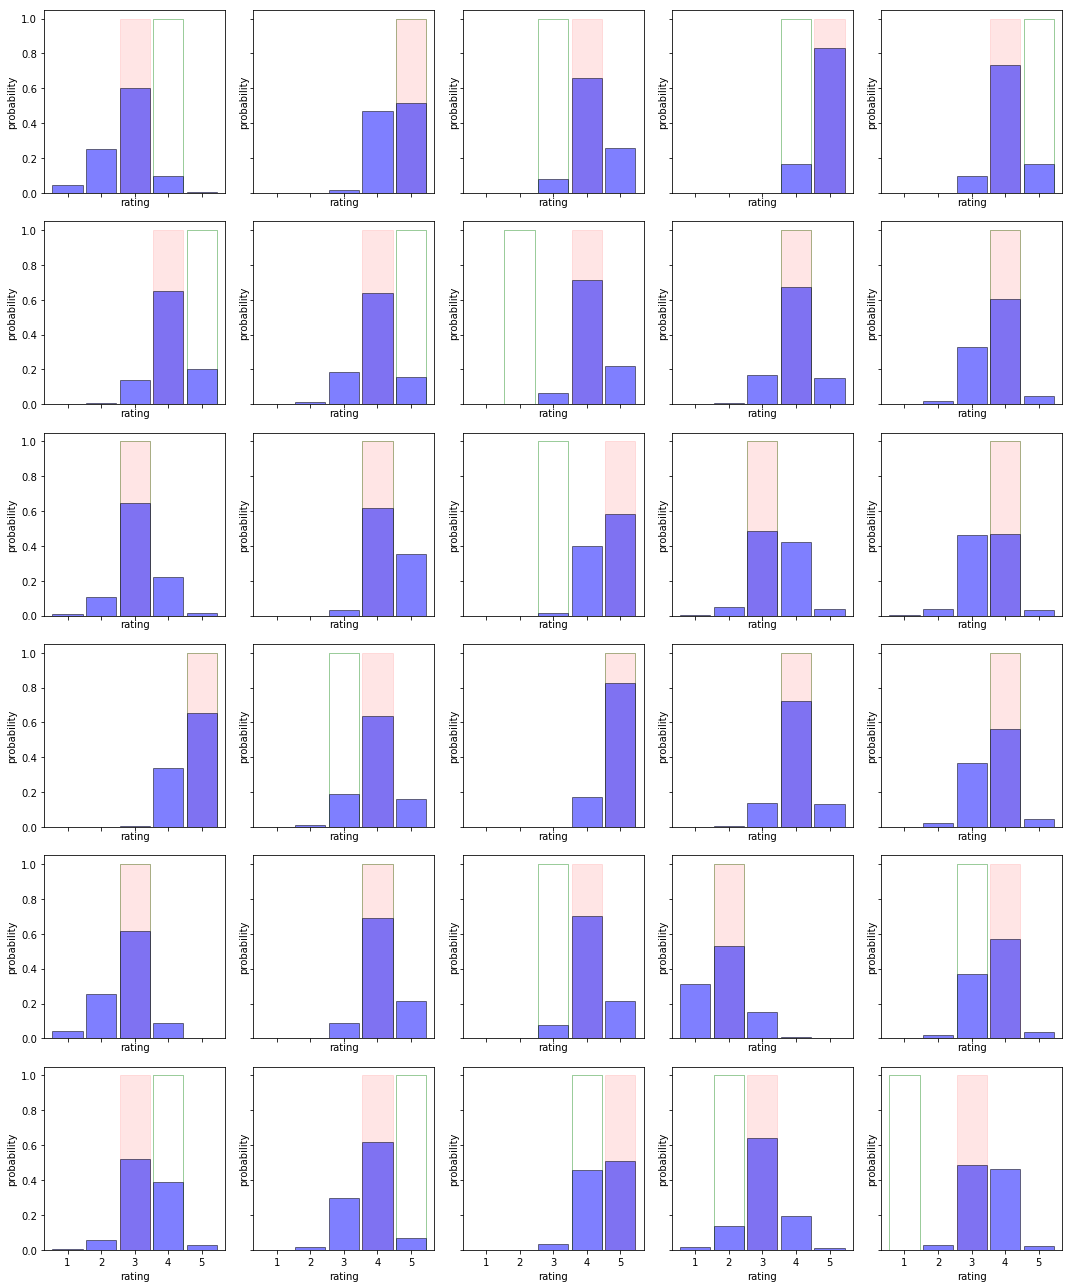

In [23]:
n_cols, n_rows = 5, 6
n = n_cols * n_rows
ratings = validset.rating.values[:n]
probs = final_valid_predictions[:n]

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), sharex=True, sharey=True)
for ax, r, ps  in zip(axs.flatten(), ratings, probs):
    for i, p in enumerate(ps):
        ax.set_xlabel("rating")
        ax.set_ylabel("probability")
        ax.bar(r, 1, .9, color="white", edgecolor="green", alpha=.1, zorder=1)
        ax.bar(i+1, p, .9, color="blue", alpha=.5, edgecolor="black", zorder=2)
        ax.set_xticks(np.arange(1, 6))
    ax.bar(np.argmax(ps, axis=-1)+1, 1, .9, color="red", edgecolor="red", alpha=.1, zorder=1)
fig.tight_layout()

In [24]:
results = validset[["gender", "userid","movieid","age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["prediction"] = final_valid_predictions.argmax(axis=1)+1
results["rating 1"] = final_valid_predictions[:,0]
results["rating 2"] = final_valid_predictions[:,1]
results["rating 3"] = final_valid_predictions[:,2]
results["rating 4"] = final_valid_predictions[:,3]
results["rating 5"] = final_valid_predictions[:,4]
results.head(10)

,gender,userid,movieid,age_desc,occ_desc,title,genre,rating,prediction,rating 1,rating 2,rating 3,rating 4,rating 5
981129,M,963,3809,25-34,other or not specified,What About Bob? (1991),Comedy,4,3,4.350096e-02,0.250565,0.603967,0.095911,0.006056
985496,M,1217,3836,25-34,programmer,Kelly's Heroes (1970),Action|Comedy|War,5,5,2.802744e-06,0.000191,0.014831,0.469968,0.515008
390574,M,4169,1345,50-55,other or not specified,Carrie (1976),Horror,3,4,8.397089e-05,0.002588,0.079945,0.661034,0.256350
668698,F,2155,2454,Under 18,K-12 student,"Fly, The (1958)",Horror|Sci-Fi,4,5,1.840532e-07,0.000015,0.001641,0.167766,0.830577
532105,F,2100,1968,25-34,other or not specified,"Breakfast Club, The (1985)",Comedy|Drama,5,4,5.042348e-05,0.002230,0.094842,0.734332,0.168545
641818,M,4626,2371,25-34,sales/marketing,Fletch (1985),Comedy,5,4,4.179878e-04,0.007681,0.136699,0.649748,0.205453
950333,M,1837,3676,25-34,artist,Eraserhead (1977),Drama|Horror,5,4,8.754965e-04,0.013166,0.186228,0.640405,0.159326
361483,M,5128,1270,50-55,executive/managerial,Back to the Future (1985),Comedy|Sci-Fi,2,4,2.307691e-05,0.001232,0.065459,0.715190,0.218096
487408,M,3041,1735,25-34,college/grad student,Great Expectations (1998),Drama|Romance,4,4,4.498234e-04,0.008934,0.166628,0.671906,0.152083
781088,M,4473,2915,35-44,academic/educator,Risky Business (1983),Comedy,4,4,6.957088e-04,0.017187,0.328794,0.603481,0.049842


In [25]:
def compute_recall(prediction_col, target_col):
    recall=[]
    for i in range(5):
        rating_df = results[results[target_col]==i+1]
        num_true_rating = len(rating_df)+0.0
        current_recall = (len(rating_df[rating_df[prediction_col]==i+1]))/num_true_rating
        recall.append(current_recall)
    return recall

def compute_precision(prediction_col, target_col): 
    precision=[]
    for i in range(5):
        pred_df = results[results[prediction_col]==i+1]
        pred_rating = len(pred_df)+0.0
        current_precision = (len(pred_df[pred_df[target_col]==i+1]))/pred_rating
        precision.append(current_precision)
    return precision    

def compute_mae(prediction_col, target_col):
    return np.mean(np.abs(results[prediction_col]-results[target_col]))

def compute_rmse(prediction_col, target_col):
    return np.sqrt(1/len(results)*np.sum((results[prediction_col]- results[target_col])**2))

In [26]:
compute_recall('prediction', 'rating')

[0.286997105216518,
 0.21371546185991394,
 0.5327710689412817,
 0.6620317387655451,
 0.4184581880251328]

In [27]:
compute_precision('prediction', 'rating')

[0.6798208788133221,
 0.3924521818806551,
 0.4492430364743279,
 0.4922703806660237,
 0.6830475092472499]

In [28]:
compute_mae('prediction', 'rating')

0.5696470407881011

In [29]:
compute_rmse('prediction', 'rating')

0.8559903400426091